In [1]:
# Importing necessary libraries for deep learning, computer vision, and data processing
import os
import random
import torch
import cv2
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import supervision as sv
from torch.utils.data import DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Configuration and paths
DATASET_NAME = 'weapons.v1i.coco'
COCO_ANNOTATION_FILENAME = "_annotations.coco.json"

# Define directory paths for train, validation, and test datasets
class DatasetPaths:
    """Centralized management of dataset directory paths"""
    TRAIN = os.path.join(DATASET_NAME, "train")
    VALIDATION = os.path.join(DATASET_NAME, "valid")
    TEST = os.path.join(DATASET_NAME, "test")

# Custom COCO dataset class for object detection
class EnhancedCocoDetection(torchvision.datasets.CocoDetection):
    """
    Enhanced COCO dataset with custom preprocessing and item retrieval
    Extends torchvision's CocoDetection with additional image processing
    """
    def __init__(
        self, 
        image_dir_path: str, 
        image_processor, 
        is_training: bool = True
    ):
        # Construct full path to annotation file
        annotation_path = os.path.join(image_dir_path, COCO_ANNOTATION_FILENAME)
        
        # Call parent constructor
        super(EnhancedCocoDetection, self).__init__(image_dir_path, annotation_path)
        
        # Store image processor for transformations
        self.image_processor = image_processor

    def __getitem__(self, index):
        """
        Custom item retrieval with preprocessing
        Converts images and annotations to model-compatible format
        """
        # Retrieve image and its annotations
        images, annotations = super(EnhancedCocoDetection, self).__getitem__(index)        
        image_id = self.ids[index]
        
        # Prepare annotations dictionary
        annotation_dict = {
            'image_id': image_id, 
            'annotations': annotations
        }
        
        # Process image and annotations
        encoding = self.image_processor(
            images=images, 
            annotations=annotation_dict, 
            return_tensors="pt"
        )
        
        # Extract processed pixel values and labels
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


In [5]:
# Initialize image processor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

# Create datasets for different stages
TRAINING_DATASET = EnhancedCocoDetection(
    image_dir_path=DatasetPaths.TRAIN, 
    image_processor=image_processor, 
    is_training=True
)
VALIDATION_DATASET = EnhancedCocoDetection(
    image_dir_path=DatasetPaths.VALIDATION, 
    image_processor=image_processor, 
    is_training=False
)
TEST_DATASET = EnhancedCocoDetection(
    image_dir_path=DatasetPaths.TEST, 
    image_processor=image_processor, 
    is_training=False
)

# Print dataset statistics
print(f"Training Examples: {len(TRAINING_DATASET)}")
print(f"Validation Examples: {len(VALIDATION_DATASET)}")
print(f"Test Examples: {len(TEST_DATASET)}")

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Training Examples: 1116
Validation Examples: 321
Test Examples: 156


In [6]:
def create_custom_collate(processor):
    """
    Create a custom collate function for DataLoader
    Handles padding and batch preparation
    """
    def collate_handler(batch):
        pixel_values = [item[0] for item in batch]
        encoding = processor.pad(pixel_values, return_tensors="pt")
        labels = [item[1] for item in batch]
        return {
            'pixel_values': encoding['pixel_values'],
            'pixel_mask': encoding['pixel_mask'],
            'labels': labels
        }
    return collate_handler

In [7]:
# Create data loaders with custom collate function
BATCH_SIZE = 4
TRAINING_LOADER = DataLoader(
    dataset=TRAINING_DATASET, 
    collate_fn=create_custom_collate(image_processor), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
VALIDATION_LOADER = DataLoader(
    dataset=VALIDATION_DATASET, 
    collate_fn=create_custom_collate(image_processor), 
    batch_size=BATCH_SIZE
)
TEST_LOADER = DataLoader(
    dataset=TEST_DATASET, 
    collate_fn=create_custom_collate(image_processor), 
    batch_size=BATCH_SIZE
)

# Dynamically create label mapping
CATEGORIES = TRAINING_DATASET.coco.cats
ID_TO_LABEL = {k: v['name'] for k, v in CATEGORIES.items()}

In [8]:
class DetectionModel(pl.LightningModule):
    """
    Lightning module for DETR object detection model
    Handles training, validation, and optimization
    """
    def __init__(
        self, 
        learning_rate=1e-4, 
        backbone_lr=1e-5, 
        weight_decay=1e-4
    ):
        super().__init__()
        # Initialize pre-trained DETR model
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50", 
            num_labels=len(ID_TO_LABEL),
            ignore_mismatched_sizes=True
        )
        
        # Store hyperparameters
        self.lr = learning_rate
        self.backbone_lr = backbone_lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        """Forward pass through the model"""
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        """Shared logic for training and validation steps"""
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        return outputs.loss, outputs.loss_dict

    def training_step(self, batch, batch_idx):
        """Custom training step with logging"""
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log(f"train_{k}", v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        """Custom validation step with logging"""
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log(f"validation_{k}", v.item())
        return loss

    def configure_optimizers(self):
        """Configure parameter groups and optimizer"""
        param_groups = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]
            },
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.backbone_lr,
            },
        ]
        return torch.optim.AdamW(param_groups, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        """Return training dataloader"""
        return TRAINING_LOADER

    def val_dataloader(self):
        """Return validation dataloader"""
        return VALIDATION_LOADER

In [9]:
# Model initialization and training configuration
detection_model = DetectionModel()

# PyTorch Lightning Trainer setup
trainer = pl.Trainer(
    max_epochs=10, 
    gradient_clip_val=0.1, 
    accumulate_grad_batches=8, 
    log_every_n_steps=5
)

# Start training
trainer.fit(detection_model)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\jiyen\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:04<00:04,  0.24it/s]

C:\Users\jiyen\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


C:\Users\jiyen\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 279/279 [14:49<00:00,  0.31it/s, v_num=2]

C:\Users\jiyen\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 9: 100%|██████████| 279/279 [20:16<00:00,  0.23it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 279/279 [20:32<00:00,  0.23it/s, v_num=2]


In [10]:
# Model saving and device management
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_SAVE_PATH = 'weapon-detection-model'
detection_model.model.save_pretrained(MODEL_SAVE_PATH)

In [11]:
# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_SAVE_PATH)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

Image #134


C:\Users\jiyen\AppData\Local\Temp\ipykernel_35432\1397110750.py:119: DeprecationWarning: from_coco_annotations is deprecated: Dataset loading and saving is going to be executed by supervision.dataset.core.Dataset
  ground_truth_detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)


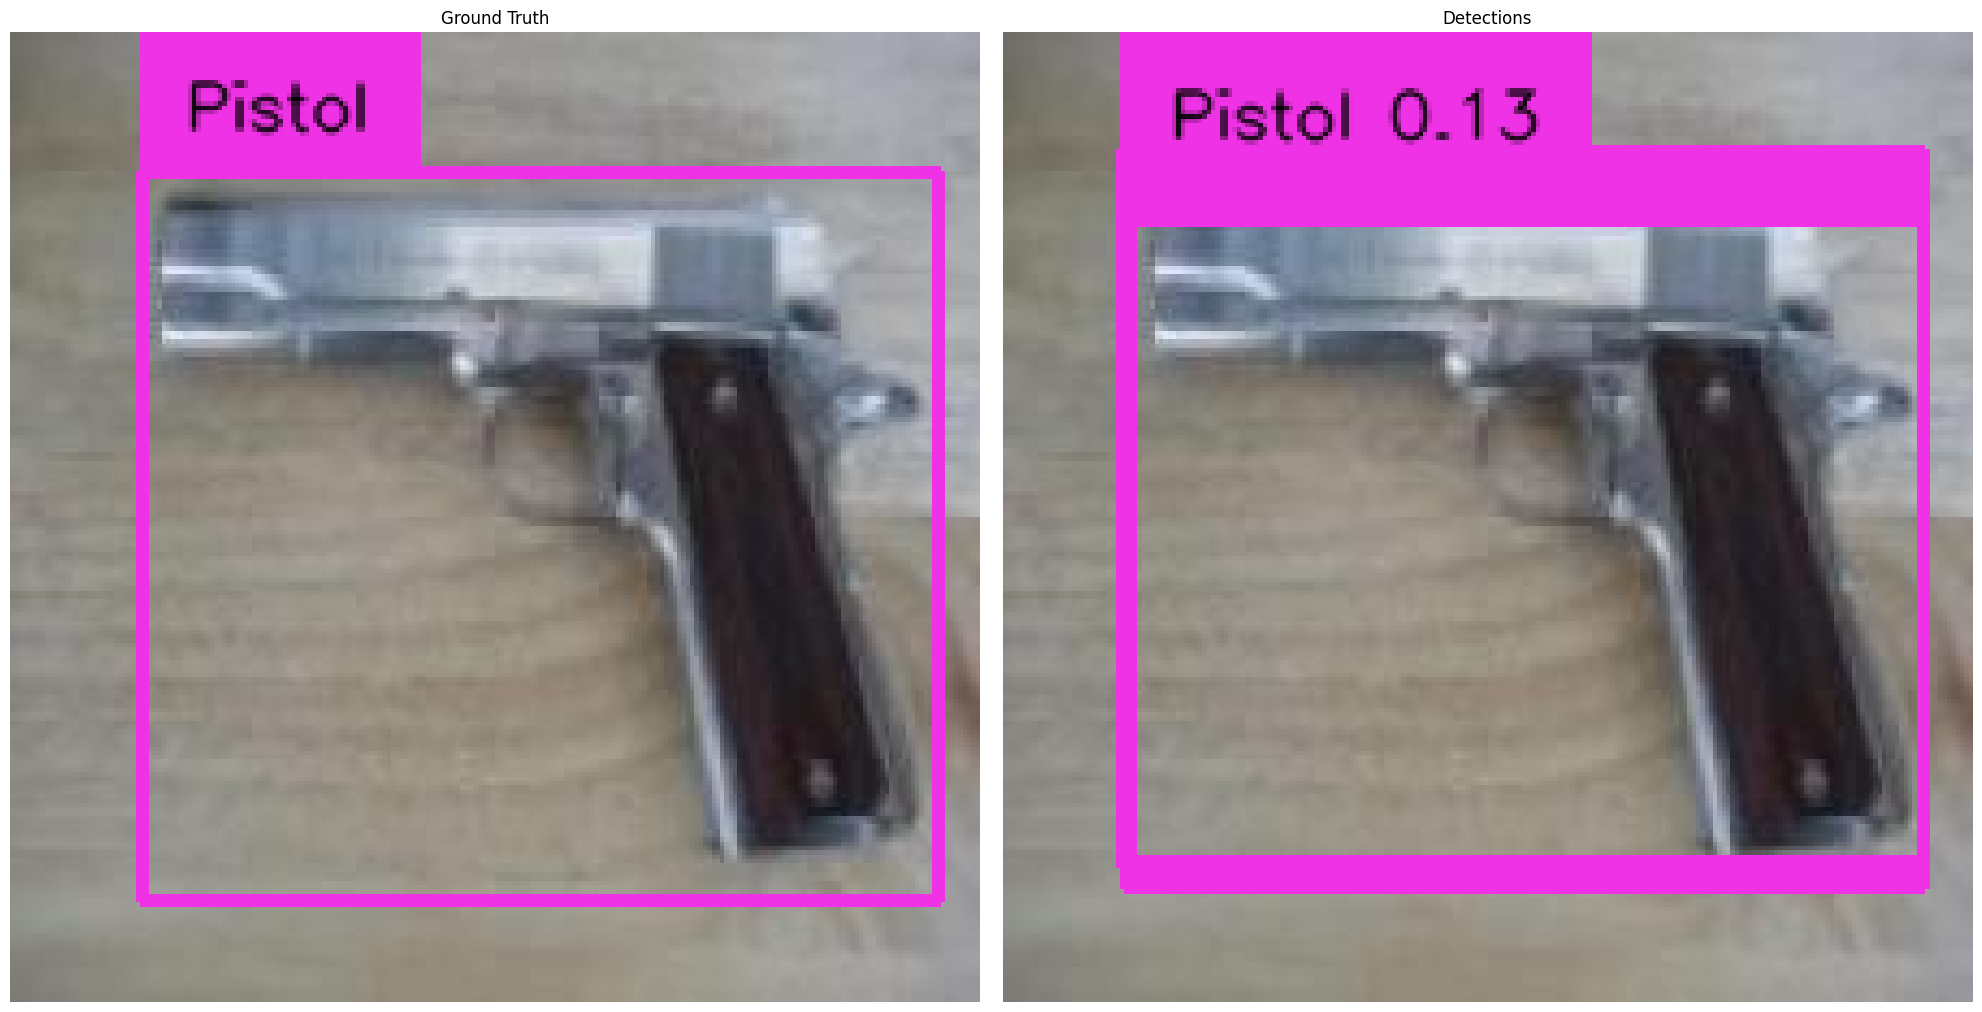

In [44]:
import os
import random
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

def load_random_image(dataset):
    """
    Load a random image from the dataset
    
    Args:
        dataset: COCO-style dataset
    
    Returns:
        tuple: (image_id, image_path, image, annotations)
    """
    # Select random image
    image_ids = dataset.coco.getImgIds()
    image_id = random.choice(image_ids)
    print(f'Image #{image_id}')

    # Load image and annotations
    image_info = dataset.coco.loadImgs(image_id)[0]
    annotations = dataset.coco.imgToAnns[image_id]
    image_path = os.path.join(dataset.root, image_info['file_name'])
    
    # Read image
    image = cv2.imread(image_path)
    
    return image_id, image_path, image, annotations

def create_detections(image, model, image_processor, device, confidence_threshold=0.1):
    """
    Perform object detection on an image
    
    Args:
        image: Input image
        model: Detection model
        image_processor: Image preprocessing utility
        device: Computing device
        confidence_threshold: Minimum confidence for detection
    
    Returns:
        Detection results
    """
    # Prepare input
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        
        # Post-process results
        target_sizes = torch.tensor([image.shape[:2]]).to(device)
        results = image_processor.post_process_object_detection(
            outputs=outputs, 
            threshold=confidence_threshold, 
            target_sizes=target_sizes
        )[0]
    
    # Convert to supervision detections
    return sv.Detections.from_transformers(transformers_results=results)

def visualize_detections(ground_truth_image, detection_image, labels):
    """
    Create side-by-side visualization of ground truth and detections
    
    Args:
        ground_truth_image: Image with ground truth annotations
        detection_image: Image with model detections
        labels: List of class labels
    """
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    
    # Ground truth subplot
    axs[0].imshow(cv2.cvtColor(ground_truth_image, cv2.COLOR_BGR2RGB))
    axs[0].axis('off')
    axs[0].set_title('Ground Truth')
    
    # Detections subplot
    axs[1].imshow(cv2.cvtColor(detection_image, cv2.COLOR_BGR2RGB))
    axs[1].axis('off')
    axs[1].set_title('Detections')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

def main(test_dataset, model, image_processor, device):
    """
    Main function to run object detection visualization
    
    Args:
        test_dataset: Dataset to sample images from
        model: Object detection model
        image_processor: Image preprocessing utility
        device: Computing device
    """
    # Predefined labels
    labels = [
        'Pistols', 'AntRevolver', 'AntRifle', 'FPistol', 'FRifle', 
        'Fknife', 'MacGun', 'Pistol', 'Revolver', 'Rifle', 
        'RifleTel', 'Uzzy', 'knife'
    ]
    
    # Confidence threshold
    CONFIDENCE_THRESHOLD = 0.1
    
    # Box annotator
    box_annotator = sv.BoxAnnotator()
    
    # Load random image
    _, _, image, annotations = load_random_image(test_dataset)
    
    # Ground truth detections
    ground_truth_detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
    label_to_insert = [f"{labels[class_id]}" for _, _, confidence, class_id, _ in ground_truth_detections]
    frame_ground_truth = box_annotator.annotate(
        scene=image.copy(), 
        detections=ground_truth_detections, 
        labels=label_to_insert
    )
    
    # Model detections
    model_detections = create_detections(
        image, 
        model, 
        image_processor, 
        device, 
        confidence_threshold=CONFIDENCE_THRESHOLD
    )
    label_to_insert = [f"{labels[class_id]} {confidence:.2f}" for _, _, confidence, class_id, _ in model_detections]
    frame_detections = box_annotator.annotate(
        scene=image.copy(), 
        detections=model_detections, 
        labels=label_to_insert
    )
    
    # Visualize results
    visualize_detections(frame_ground_truth, frame_detections, labels)

# Assuming these are defined elsewhere in your script
main(TEST_DATASET, model, image_processor, DEVICE)

In [49]:
import torch
import numpy as np
from typing import List, Dict, Tuple

def calculate_iou(box1: torch.Tensor, box2: torch.Tensor) -> float:
    """
    Calculate Intersection over Union (IoU) between two bounding boxes
    
    Args:
        box1 (torch.Tensor): First bounding box [x_min, y_min, x_max, y_max]
        box2 (torch.Tensor): Second bounding box [x_min, y_min, x_max, y_max]
    
    Returns:
        float: Intersection over Union value
    """
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    
    # Calculate IoU
    return intersection / union if union > 0 else 0.0

def calculate_precision_recall(
    gt_boxes: List[torch.Tensor], 
    pred_boxes: List[torch.Tensor], 
    gt_labels: List[int], 
    pred_labels: List[int], 
    pred_scores: List[float], 
    iou_threshold: float = 0.5
) -> Tuple[List[float], List[float]]:
    """
    Calculate precision and recall for a single class
    
    Args:
        gt_boxes: Ground truth bounding boxes
        pred_boxes: Predicted bounding boxes
        gt_labels: Ground truth labels
        pred_labels: Predicted labels
        pred_scores: Prediction confidence scores
        iou_threshold: IoU threshold for considering a detection correct
    
    Returns:
        Precision and recall lists
    """
    # Sort predictions by confidence score
    sorted_indices = sorted(
        range(len(pred_scores)), 
        key=lambda k: pred_scores[k], 
        reverse=True
    )
    
    # Track true positives and false positives
    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    
    # Track ground truth boxes that have been matched
    gt_matched = [False] * len(gt_boxes)
    
    for idx, sorted_idx in enumerate(sorted_indices):
        # Skip if predicted label doesn't match
        if pred_labels[sorted_idx] not in gt_labels:
            fp[idx] = 1
            continue
        
        # Find best matching ground truth box
        best_iou = 0
        best_gt_idx = -1
        
        for gt_idx, gt_box in enumerate(gt_boxes):
            if gt_matched[gt_idx]:
                continue
            
            iou = calculate_iou(pred_boxes[sorted_idx], gt_box)
            
            if iou > best_iou and iou >= iou_threshold:
                best_iou = iou
                best_gt_idx = gt_idx
        
        # Mark detection result
        if best_gt_idx != -1:
            tp[idx] = 1
            gt_matched[best_gt_idx] = True
        else:
            fp[idx] = 1
    
    # Cumulative true positives and false positives
    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    
    # Calculate precision and recall
    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / len(gt_boxes) if len(gt_boxes) > 0 else np.zeros_like(precision)
    
    return precision.tolist(), recall.tolist()

def calculate_average_precision(
    precision: List[float], 
    recall: List[float]
) -> float:
    """
    Calculate Average Precision using the VOC method
    
    Args:
        precision: List of precision values
        recall: List of recall values
    
    Returns:
        Average Precision value
    """
    # Interpolated precision
    mrec = [0.0] + recall + [1.0]
    mpre = [0.0] + precision + [0.0]
    
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    
    # Calculate AP
    ap = 0.0
    for i in range(len(mrec)-1):
        ap += ((mrec[i+1] - mrec[i]) * mpre[i+1])
    
    return ap

def calculate_map(
    all_gt_boxes: Dict[int, List[torch.Tensor]],
    all_pred_boxes: Dict[int, List[torch.Tensor]],
    all_pred_labels: Dict[int, List[int]],
    all_pred_scores: Dict[int, List[float]],
    num_classes: int,
    iou_threshold: float = 0.5
) -> Tuple[float, Dict[int, float]]:
    """
    Calculate Mean Average Precision (mAP)
    
    Args:
        all_gt_boxes: Ground truth boxes for all images, by class
        all_pred_boxes: Predicted boxes for all images, by class
        all_pred_labels: Predicted labels for all images, by class
        all_pred_scores: Prediction confidence scores for all images, by class
        num_classes: Total number of classes
        iou_threshold: IoU threshold for correct detection
    
    Returns:
        Mean Average Precision and per-class Average Precision
    """
    per_class_ap = {}
    
    for cls in range(num_classes):
        # Collect ground truth and predictions for this class
        gt_boxes = [box for img_boxes in all_gt_boxes.values() for box in img_boxes 
                    if box[4] == cls]
        
        # Check if class exists in dataset
        if not gt_boxes:
            per_class_ap[cls] = 0.0
            continue
        
        pred_boxes = []
        pred_labels = []
        pred_scores = []
        
        # Collect predictions
        for img_pred_boxes, img_pred_labels, img_pred_scores in zip(
            all_pred_boxes.values(), 
            all_pred_labels.values(), 
            all_pred_scores.values()
        ):
            for box, label, score in zip(img_pred_boxes, img_pred_labels, img_pred_scores):
                if label == cls:
                    pred_boxes.append(box)
                    pred_labels.append(label)
                    pred_scores.append(score)
        
        # Calculate precision and recall
        precision, recall = calculate_precision_recall(
            gt_boxes, 
            pred_boxes, 
            [cls] * len(gt_boxes), 
            pred_labels, 
            pred_scores, 
            iou_threshold
        )
        
        # Calculate Average Precision
        ap = calculate_average_precision(precision, recall)
        per_class_ap[cls] = ap
    
    # Calculate mean Average Precision
    mAP = np.mean(list(per_class_ap.values()))
    
    return mAP, per_class_ap

def prepare_detection_data(
    dataset, 
    model, 
    image_processor, 
    device, 
    confidence_threshold: float = 0.1
) -> Tuple[Dict, Dict, Dict, Dict]:
    """
    Prepare ground truth and predicted detection data from the dataset
    
    Args:
        dataset: Test dataset
        model: Object detection model
        image_processor: Image preprocessing utility
        device: Computing device
        confidence_threshold: Minimum confidence for detection
    
    Returns:
        Dictionaries of ground truth and predicted boxes, labels, and scores
    """
    all_gt_boxes = {}
    all_pred_boxes = {}
    all_pred_labels = {}
    all_pred_scores = {}
    
    for idx in range(len(dataset)):
        # Load image and annotations
        image_id, _, image, annotations = load_random_image(dataset)
        
        # Prepare ground truth data
        gt_boxes = []
        for ann in annotations:
            x, y, w, h = ann['bbox']
            gt_boxes.append(torch.tensor([x, y, x+w, y+h, ann['category_id']]))
        all_gt_boxes[image_id] = gt_boxes
        
        # Perform inference
        inputs = image_processor(images=image, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            target_sizes = torch.tensor([image.shape[:2]]).to(device)
            results = image_processor.post_process_object_detection(
                outputs=outputs, 
                threshold=confidence_threshold, 
                target_sizes=target_sizes
            )[0]
        
        # Prepare predicted data
        pred_boxes = []
        pred_labels = []
        pred_scores = []
        for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
            pred_boxes.append(torch.cat([box, torch.tensor([label.item()]).to(DEVICE)]).to(DEVICE))
            pred_labels.append(label.item())
            pred_scores.append(score.item())
        
        all_pred_boxes[image_id] = pred_boxes
        all_pred_labels[image_id] = pred_labels
        all_pred_scores[image_id] = pred_scores
    
    return all_gt_boxes, all_pred_boxes, all_pred_labels, all_pred_scores

def evaluate_model_map(
    test_dataset, 
    model, 
    image_processor, 
    device, 
    num_classes: int,
    confidence_threshold: float = 0.1,
    iou_threshold: float = 0.5
):
    """
    Comprehensive model evaluation with mAP
    
    Args:
        test_dataset: Test dataset
        model: Object detection model
        image_processor: Image preprocessing utility
        device: Computing device
        num_classes: Total number of classes
        confidence_threshold: Minimum confidence for detection
        iou_threshold: IoU threshold for correct detection
    
    Returns:
        Mean Average Precision and per-class Average Precision
    """
    # Prepare detection data
    all_gt_boxes, all_pred_boxes, all_pred_labels, all_pred_scores = prepare_detection_data(
        test_dataset, 
        model, 
        image_processor, 
        device, 
        confidence_threshold
    )
    
    # Calculate mAP
    mAP, per_class_ap = calculate_map(
        all_gt_boxes, 
        all_pred_boxes, 
        all_pred_labels, 
        all_pred_scores, 
        num_classes, 
        iou_threshold
    )
    
    return mAP, per_class_ap

# Example usage
mAP, per_class_ap = evaluate_model_map(
    VALIDATION_DATASET, 
    model, 
    image_processor, 
    DEVICE, 
    num_classes=len(ID_TO_LABEL)
)
print(f"Mean Average Precision: {mAP*100:.2f}%")
print("Per-class Average Precision:")
for cls, ap in per_class_ap.items():
    print(f"{ID_TO_LABEL.get(cls, f'Class {cls}')}: {ap*100:.2f}%")

Image #103
Image #313
Image #169
Image #92
Image #258
Image #182
Image #183
Image #208
Image #246
Image #204
Image #165
Image #212
Image #99
Image #259
Image #243
Image #149
Image #51
Image #265
Image #160
Image #11
Image #151
Image #197
Image #262
Image #102
Image #80
Image #164
Image #159
Image #217
Image #17
Image #63
Image #133
Image #127
Image #128
Image #75
Image #188
Image #278
Image #127
Image #95
Image #226
Image #180
Image #144
Image #85
Image #135
Image #274
Image #288
Image #110
Image #98
Image #26
Image #301
Image #199
Image #294
Image #10
Image #115
Image #106
Image #197
Image #0
Image #126
Image #215
Image #178
Image #178
Image #11
Image #301
Image #309
Image #200
Image #49
Image #312
Image #91
Image #144
Image #167
Image #74
Image #228
Image #201
Image #204
Image #73
Image #9
Image #190
Image #118
Image #223
Image #113
Image #294
Image #136
Image #164
Image #190
Image #36
Image #305
Image #156
Image #152
Image #166
Image #31
Image #59
Image #25
Image #13
Image #251
Imag